# **Exploración Preliminar archivos Yelp**

El objetivo de este notebook es poder entender la naturaleza, formato y estructuras que contienen los archivos de Yelp, de tal modo que nos permita posteriormente realizar un proceso de ETL para preparar el datawarehouse. El análisis se realizo en los siguientes archivos:
- business.pkl
- review.json
- user.parquet
- checkin.json
- tip.json

## **Librerias utlizadas**

In [31]:
#AÑADIR CADA NUEVA LIBRERIA QUE SE UTILICE
import pandas as pd
import numpy as np
import requests
import glob
import matplotlib.pyplot as plt


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Business**

## **2. Review**

In [ ]:
!pip install pyspark -v

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Running command python setup.py egg_info
  /usr/local/lib/python3.10/dist-packages/setuptools/dist.py:755: SetuptoolsDeprecationWarning: Invalid dash-separated options
  !!

          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.

          By 2023-Sep-26, you need to update your project and remove deprecated calls
          or your builds will no longer be supported.

          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************

  !!
    opt = self.warn_dash_deprecation(opt, section)
  running egg_info
 

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("Load-json-to-pyspark-dataframe").getOrCreate()

In [ ]:
review = spark.read.option("lines","true").option("mode", "PERMISSIVE").json('/content/drive/MyDrive/Final Project /Yelp/review.json')

Pasar la base de datos a formato parquet

In [ ]:
review = review.repartition(10)
review.write.format('parquet').save('/content/drive/MyDrive/Final Project /Yelp/review.parquet')

In [13]:

def concatenar_archivos_parquet(ruta_base):
    lista_archivos = glob.glob(ruta_base + "part-*.parquet")
    lista_df = []
    for ruta_archivo in lista_archivos:
        archivo = pd.read_parquet(ruta_archivo)
        lista_df.append(archivo)
    df_concatenado = pd.concat(lista_df)
    return df_concatenado

In [16]:
ruta_base = "/content/drive/MyDrive/Final Project /Yelp/review.parquet/"

df_concatenado = concatenar_archivos_parquet(ruta_base)

Dimensión de la base de datos

In [17]:
df_concatenado.shape

(6990280, 9)

Buscar solo los registros que contengan palabras afines al analisis

In [18]:
palabras = ["meat", "roast", "beef", "steak"]
mascara = df_concatenado['text'].str.contains('|'.join(palabras))
df_final = df_concatenado[mascara]

Dimension del dataframe final

In [20]:
df_final.shape

(740028, 9)

Valores nulos e informacion general

In [19]:
df_final.isna().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740028 entries, 10 to 699006
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   business_id  740028 non-null  object 
 1   cool         740028 non-null  int64  
 2   date         740028 non-null  object 
 3   funny        740028 non-null  int64  
 4   review_id    740028 non-null  object 
 5   stars        740028 non-null  float64
 6   text         740028 non-null  object 
 7   useful       740028 non-null  int64  
 8   user_id      740028 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 56.5+ MB


In [22]:
df_final.describe()

,cool,funny,stars,useful
count,740028.000000,740028.000000,740028.000000,740028.000000
mean,0.787593,0.478593,3.814880,1.500955
std,3.087402,2.350815,1.300026,3.761798
min,-1.000000,-1.000000,1.000000,-1.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,4.000000,1.000000
75%,1.000000,0.000000,5.000000,2.000000
max,400.000000,375.000000,5.000000,400.000000


In [29]:
df_final.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
10,EpREWeEpmR8f1qLHzzF0AA,0,2016-01-23 18:12:09,0,Z3mRrLxEhr22QtQSt4qG4w,4.0,It's a great place to hang out for a few beers...,0,Ue10CO74ub6AeTI8u7-RNw
15,kkcQYuF3w5iHnHMf0EnRhQ,0,2015-03-05 18:04:58,0,U1VgfQ3CegUgX2GnS6OKUA,5.0,When I venture into the city its usually in th...,4,tg2NumE_Zfy8sObhnotRew
27,1ig2AJg8A08_XA3pFAMiRQ,0,2011-12-02 20:31:56,0,A6C3IJz4dtc7w1L-RHm0fg,5.0,Best steak EVER!!! Coffee cured filet is my f...,0,cCljNhHrJkfMY2l-LxO6ZA
29,kkcQYuF3w5iHnHMf0EnRhQ,1,2015-07-05 16:16:59,0,ASNAFrUepIa2SM2IheAUUQ,5.0,Drove down from Fox Chase last weekend and was...,0,NCnHoYvkZArEc2x_l5S1Sg
46,d3v51cMiLdNvn0GevIQDeg,2,2013-12-08 19:39:36,1,k1KU_3-QE81Nf9V_skbbyw,3.0,"Katy Perry, kissed a girl and liked it. I had...",4,bYENop4BuQepBjM1-BI3fA


Ver cantidad de negocios y cantidad de usuarios

In [23]:
cantidad_negocios = df_final['business_id'].nunique()

print("Cantidad de negocios:", cantidad_negocios)

Cantidad de negocios: 51379


In [24]:
cantidad_usuarios = df_final['user_id'].nunique()

print("Cantidad de usuarios:", cantidad_usuarios)

Cantidad de usuarios: 340828


Los outliers segun la columna "useful" y "cool" pueden brindar informacion relevante segun los usuarios

In [25]:
mean = df_final['useful'].mean()
std = df_final['useful'].std()

threshold = 3 * std
outliers = (df_final['useful'] < (mean - threshold)) | (df_final['useful'] > (mean + threshold))

outliers_useful = df_final[outliers]
outliers_useful.shape

(8841, 9)

In [26]:
mean = df_final['cool'].mean()
std = df_final['cool'].std()

threshold = 3 * std
outliers = (df_final['cool'] < (mean - threshold)) | (df_final['cool'] > (mean + threshold))

outliers_cool = df_final[outliers]
outliers_cool.shape

(6778, 9)

Consultar los business_id con mas cantidad de reseñas

In [27]:

resenas_por_business = df_final.groupby('business_id').size().reset_index(name='num_reseñas')

# Ordenar los 'business_id' por cantidad de reseñas en orden descendente
resenas_por_business = resenas_por_business.sort_values('num_reseñas', ascending=False)

# Tomar los 20 primeros 'business_id' con mayor cantidad de reseñas
top_20_business = resenas_por_business.head(20)

# Mostrar los 20 business_id con más reseñas en un DataFrame
print(top_20_business)

                  business_id  num_reseñas
21080  PP3BBaVxZLcJU54uP_wL6Q         3595
15797  IkY2ticzHEn4QFn8hQLSWg         2859
22689  RQAF6a0akMiot5lZZnMNNw         2435
45255  sTPueJEwcRDj7ZJmG7okYA         2430
33537  dsfRniRgfbDjC8os848B6A         1913
43280  q-zV08jt6U-q05SMEuQJAQ         1690
50493  ytynqOUb3hjKeJfRj5Tshw         1580
15615  IWHdx0NhDKADkGOgXgOFKQ         1562
652    -mIlmp5l4hKlp1tvHRdvTg         1492
17919  LM54ufrINJWoTN5imV8Etw         1425
22887  ReV4Q3rEJ8neicQPc6pC0w         1336
35642  gTC8IQ_i8zXytWSly3Ttvg         1134
32226  cGX-1IUwXOjkUqZbkKYcjw         1128
38442  jxEMFqwDJXjCxmcm5t5jVQ         1127
15668  I_3LMZ_1m2mzR0oLIOePIg         1120
41590  ntiIq1FNqduOyyowMFGh5A         1094
6207   6a4gLLFSgr-Q6CZXDLzBGQ         1012
37276  iSRTaT9WngzB8JJ2YKJUig          890
1528   0oSSjekU-3GR8gselReWnA          865
24471  TcNZXteosegb1RO4O5hREw          856


Consultar los usuarios que han escritos mas reseñas

In [28]:
conteo_reseñas_por_usuario = df_final.groupby('user_id').size()

# Ordenar en orden descendente y seleccionar los 20 usuarios con más reseñas
usuarios_mas_reseñas = conteo_reseñas_por_usuario.nlargest(20)

# Imprimir los 20 usuarios con más reseñas
print(usuarios_mas_reseñas)

user_id
vmUqcqMjlWoBM6qfmUXgyQ    739
fr1Hz2acAb3OaL3l6DyKNg    635
-G7Zkl1wIWBBmD0KRy_sCw    493
AaJ9d4OrFmgc4S_U2QiSZg    419
bYENop4BuQepBjM1-BI3fA    411
wXdbkFZsfDR7utJvbWElyA    406
ouODopBKF3AqfCkuQEnrDg    396
eTvp_hYnsrI5-ow_sQ31_g    335
_BcWyKQL16ndpBdggh2kNA    319
VL12EhEdT4OWqGq0nIqkzw    316
qjfMBIZpQT9DDtw_BWCopQ    307
vffKQc_WQMYFGY4JS5VAOw    307
8VNmuYmFboXleIFf-stnFg    306
pou3BbKsIozfH50rxmnMew    306
vHc-UrI9yfL_pnnc6nJtyQ    291
1HM81n6n4iPIFU5d2Lokhw    282
zYFGMy1_thjMnvQLX6JNBw    271
ET8n-r7glWYqZhuR6GcdNw    269
kO30XR2WeF6bla6dK1ZZLw    255
Xw7ZjaGfr0WNVt6s_5KZfA    249
dtype: int64


Comportamiento de los usuarios. Grafico de las horas en que se realizan mas reseñas

<ipython-input-32-52606263a07c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date'] = pd.to_datetime(df_final['date'])
<ipython-input-32-52606263a07c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['hora'] = df_final['date'].dt.hour


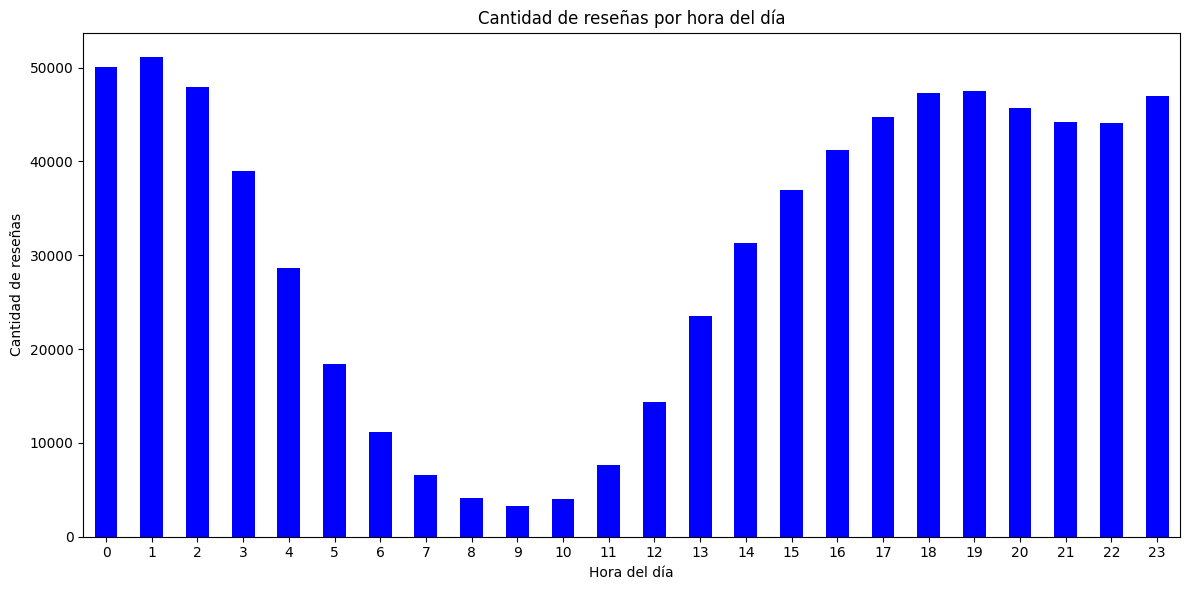

In [32]:
df_final['date'] = pd.to_datetime(df_final['date'])

# Obtener la hora para cada fecha
df_final['hora'] = df_final['date'].dt.hour

# Contar la cantidad de reseñas por hora
resenas_por_hora = df_final['hora'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
resenas_por_hora.plot(kind='bar', color='blue')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de reseñas')
plt.title('Cantidad de reseñas por hora del día')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## **3. User**

## **4. Checkin**

In [ ]:
# Leemos el documento "chekin" en formato json.
chekin = pd.read_json('/content/drive/MyDrive/Final Project /Yelp/checkin.json', lines=True)

# Observamos el dataframe "chekin" con las columnas y los datos que contienen.
chekin.sample(5)

,business_id,date
113552,r9h2tC9eSpgWAbp7hw1QvA,"2017-01-16 17:27:50, 2017-01-20 20:18:27, 2017..."
113979,rMqWPcEwfnUZ-f8coYHEsA,2012-05-18 14:09:04
88788,f8gfe7S-T15ll2sMURVeqg,"2016-08-03 15:04:48, 2016-11-15 20:04:44, 2016..."
65224,UhA77Rfgcm46B7pUDCVh4g,"2020-08-31 21:03:38, 2020-08-31 23:22:32, 2020..."
86501,e2xecLS4kmy87QdA0QI-Ew,2016-06-09 00:21:48


In [ ]:
# Obtenemos la información del dataframe como los nombres de las columnas, los valores totales, si cuentan con nulos y los tipos de datos.
chekin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131930 entries, 0 to 131929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  131930 non-null  object
 1   date         131930 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


##**Comentarios:**
El dataframe cuenta con dos columnas, "business_id" y "date". Las fechas están conjuntas separadas en comas en formato object. Por lo que se realizará un EDA en donde podremos observer el ID con más fechas separadas y el ID con fecha más antigua y con la fecha más nueva.

4.1. ID con más fechas separadas

In [ ]:
# Creamos una función para contar las fechas de la columna "date".
def contar_fechas(fila):
    # Dividimos la cadena en fechas usando la coma como separador y contamos los elementos.
    fechas = fila.split(', ')
    return len(fechas)

# Aplicamos la función a la columna "date" y creamos una nueva columna 'cantidad_fechas'
chekin['cantidad_fechas'] = chekin['date'].apply(contar_fechas)

# Observamos los cambios en el dataframe.
chekin.sample(5)

,business_id,date,cantidad_fechas
80759,bGPP22tfSHkc5OkYARGZBA,"2010-06-12 17:31:49, 2010-06-12 21:32:41, 2011...",120
45384,L1HNEw8NOWGGH3Uyttns4A,"2010-11-27 02:51:15, 2011-04-23 21:50:25, 2011...",47
124505,wRMdz34j57AUAQc28v9-hQ,"2010-07-10 01:14:53, 2010-08-08 00:50:41, 2010...",1855
114901,rqD6cyApke-O-SkppUogTg,"2010-01-23 15:58:06, 2010-03-27 14:46:02, 2011...",39
106461,nl33PVk5w9JIqOlEGPS_ZA,"2011-01-09 16:09:26, 2011-04-02 01:56:52, 2011...",26


In [ ]:
# Encontramos el ID con la cantidad máxima de fechas.
id_max_fechas = chekin.loc[chekin['cantidad_fechas'].idxmax()]['business_id']

# Observamos el id que tiene la cantidad máxima de fechas.
id_max_fechas

'-QI8Qi8XWH3D8y8ethnajA'

4.2. ID's con fechas antiguas y fechas recientes

In [ ]:
# Dividimos las fechas en una columna por comas.
chekin['fechas'] = chekin['date'].str.split(',')

# Duplicamos las filas para cada fecha con su respectivo ID.
chekin=chekin.explode('fechas').reset_index(drop=True)

# Eliminamos la columna original.
chekin.drop('date',axis=1,inplace=True)

# Observamos los cambios en el dataframe.
chekin.head(5)

,business_id,cantidad_fechas,fechas
0,---kPU91CF4Lq2-WlRu9Lw,11,2020-03-13 21:10:56
1,---kPU91CF4Lq2-WlRu9Lw,11,2020-06-02 22:18:06
2,---kPU91CF4Lq2-WlRu9Lw,11,2020-07-24 22:42:27
3,---kPU91CF4Lq2-WlRu9Lw,11,2020-10-24 21:36:13
4,---kPU91CF4Lq2-WlRu9Lw,11,2020-12-09 21:23:33


In [ ]:
# Buscamos el ID con la fecha más antigua.
fecha_minima = chekin['fechas'].min()
id_fecha_minima = chekin.loc[chekin['fechas'] == fecha_minima]
id_fecha_minima

,business_id,cantidad_fechas,fechas
8511938,cFk2SMsJ-2cmXKLFFkP9JA,587,2010-01-17 02:15:25


In [ ]:
# Buscamos el ID con la fecha más reciente.
fecha_maxima = chekin['fechas'].max()
id_fecha_maxima = chekin.loc[chekin['fechas'] == fecha_maxima]
id_fecha_maxima

,business_id,cantidad_fechas,fechas
3188598,DjpCcVUuolhT6FF78W1aQw,1,2022-01-19 01:15:21


In [ ]:
# Transformamos la columna "fechas" en el formato datetime "aaaa-mm-dd".
chekin['fechas'] = pd.to_datetime(chekin['fechas'],  errors='coerce').dt.strftime('%Y-%m-%d')
chekin.sample(5)

,business_id,cantidad_fechas,fechas
7352668,Xdy7tkuV0ViNFVxcsL4wjA,126,2021-06-05
310509,06pNHtxgPhGhZpM0Z2uzNw,2364,2016-10-14
548544,1KpNlu8VM8ukw3uOzmMFPA,1042,2013-05-12
8158360,abvsCLYEOvhsWSlgiTvbCQ,90,2018-12-19
11385795,q6hWVlVeiCgMgM22wt1wfw,2326,2015-04-18


## **5. Tip**